# Project Section2 - Machine Learning
## AI-08-박우석

## 프로젝트 데이터 : Rain in Australia
호주의 여러 지역에서 측정된 온도, 풍향, 습도 등 주어진 데이터를 통해 다음날 비가 왔는지를 예측해 볼 수 있다.

**Target : RainTomorrow (Yes or No)**

### 데이터를 선정한 이유
기상청에서도 잘 예측하지 못하여 우리가 늘 불평하는 날씨 예보. 우리 스스로는 얼마나 정확하게 이를 예측할 수 있는지 머신러닝으로 확인해 보고 싶었다.

- 문제의 유형 -> yes or no 를 판별하는 것이므로 **Classification** 문제로 접근한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report


from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

import missingno as msno
import seaborn as sns

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import randint, uniform



In [2]:
pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv').head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Baseline model 설정 : 항상 비가 오지 않는 것으로 예측

In [3]:
aus_base = pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv')

# yes -> 1, no -> 0 으로 바꾸어줌
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    
aus_base['RainToday'] = aus_base['RainToday'].apply(yesno)
aus_base['RainTomorrow'] = aus_base['RainTomorrow'].apply(yesno)

# 결측치 제거
aus_base = aus_base.dropna(subset=['RainToday', 'RainTomorrow'])

# baseline model - 항상 비가 오지 않을 것으로 예측
y_pred_base = pd.DataFrame({'RainTomorrow':np.zeros(len(aus_base['RainToday']))})
y_test = aus_base[['RainTomorrow']]

accuracy = classification_report(y_test[:-1], y_pred_base[:-1])
print(accuracy)

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88    109585
         1.0       0.00      0.00      0.00     31201

    accuracy                           0.78    140786
   macro avg       0.39      0.50      0.44    140786
weighted avg       0.61      0.78      0.68    140786



/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

baseline model 결과:  
이미 accuracy가 78%에 달한다. 상당한 imbalance가 타겟에 존재하기 때문.  
averaged f1 score : 0.44

### EDA 및 데이터 전처리

<AxesSubplot:>

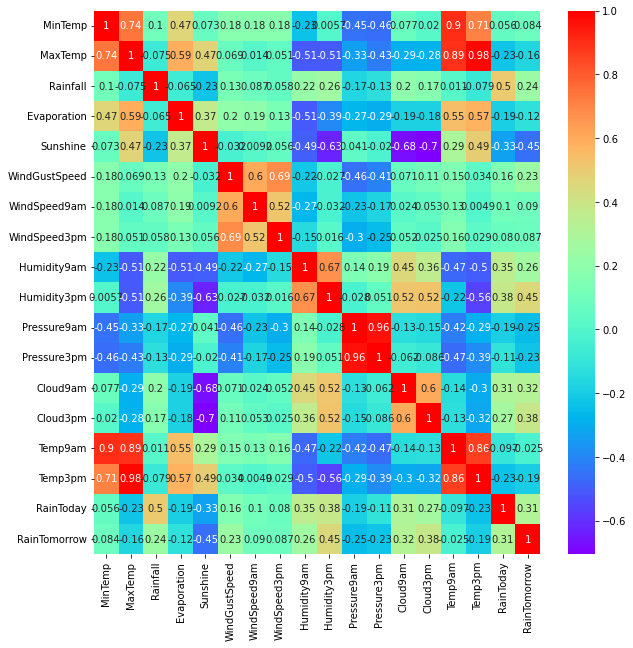

In [4]:
# feature 간의 correlation 파악하기 
# 높은 correlation 보이는 feature들은 통일하거나 없앤다.

plt.figure(figsize=(10,10))
sns.heatmap(aus_base.corr(),
           annot=True,
           cmap='rainbow')

<AxesSubplot:>

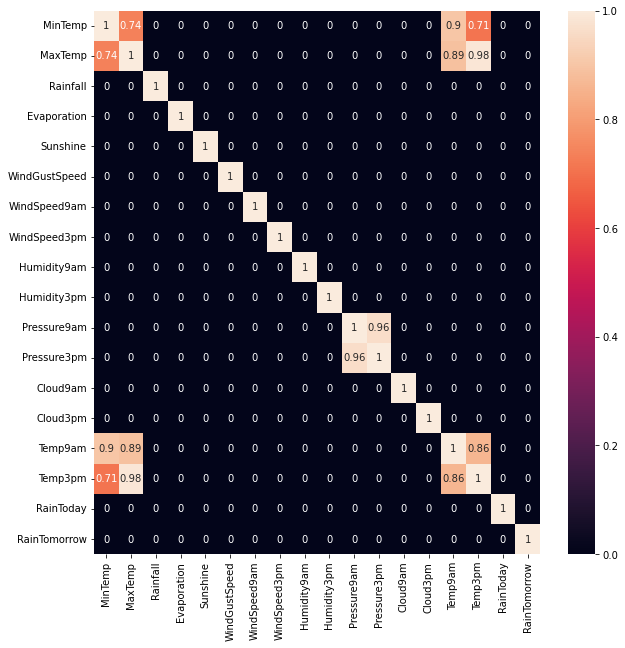

In [5]:
aus_base_high = aus_base.corr().copy()
aus_base_high[~(aus_base_high > 0.7) ] = 0

plt.figure(figsize=(10,10))
sns.heatmap(aus_base_high,
           annot=True,
           )

Temperature 그리고 pressure 끼리 상당히 높은 correlation을 보이고 있다.  
따라서 mean Temperature / mean pressure 지표를 만들어 통일한다.

#### 결측치 확인

<AxesSubplot:>

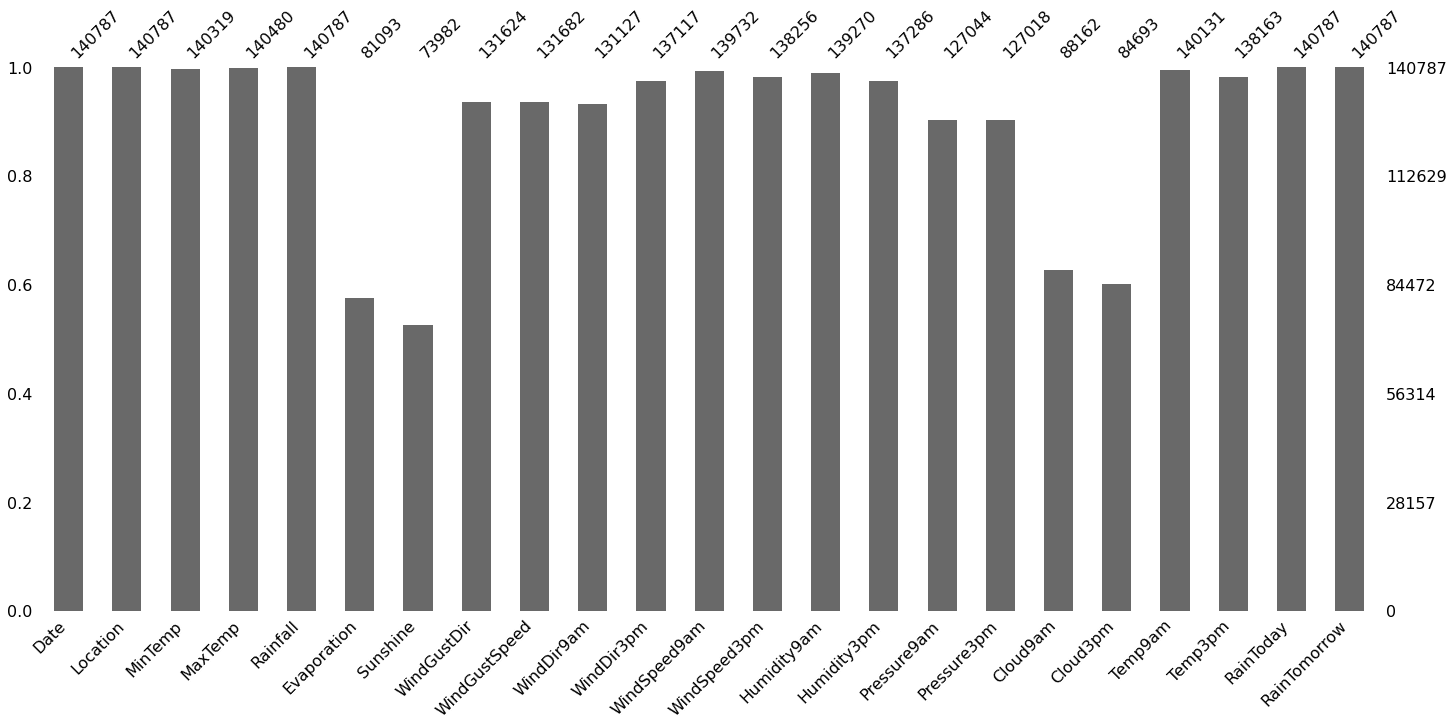

In [6]:
%matplotlib inline
msno.bar(aus_base)

Evaporation, Sunshine, Cloud는 너무 결측치가 많고 유추하기도 힘들기 때문에 관련 파라미터는 모두 제거한다.

### 데이터 전처리

In [7]:
aus = pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv')
print(aus.shape)


#RainToday, RainTomorrow 결측치 행 제거
aus = aus.dropna(subset=['RainToday','RainTomorrow'])

# evaporation, sunshine, cloud는 너무 결측치가 많고 유추하기도 힘들다. 따라서 그냥 제거한다
aus = aus.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)

#기타 결측치 제거
aus = aus.dropna()
print('After dropna:',aus.shape)


#RainToday and RainTomorrow values change to 0 and 1
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
aus['RainToday'] = aus['RainToday'].apply(yesno)
aus['RainTomorrow'] = aus['RainTomorrow'].apply(yesno)

#meanTemp 계산
aus['MeanTemp'] = aus.loc[:,['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].mean(axis=1)

#meanpressure 계산
aus['MeanPressure'] = aus.loc[:,['Pressure9am', 'Pressure3pm']].mean(axis=1)





(145460, 23)
After dropna: (112925, 19)


WindDir (바람의 방향) : 16가지 방향으로 나뉘어져 있다. 이를 manual 하게 동쪽 : 0 부터 시계방향으로 0~15까지 숫자를 매겼다

In [8]:
aus.loc[:,['WindGustDir', 'WindDir9am', 'WindDir3pm']]

,WindGustDir,WindDir9am,WindDir3pm
0,W,W,WNW
1,WNW,NNW,WSW
2,WSW,W,WSW
3,NE,SE,E
4,W,ENE,NW
...,...,...,...
145454,E,ESE,E
145455,E,SE,ENE
145456,NNW,SE,N
145457,N,SE,WNW


In [9]:
# WindDir manual encoding

def dir_to_num(valdir):

    ref = {'E':0,
         'ESE':1,
         'SE':2,
         'SSE':3,
         'S':4,
         'SSW':5,
         'SW':6,
         'WSW':7,
         'W':8,
         'WNW':9,
         'NW':10,
         'NNW':11,
         'N':12,
         'NNE':13,
         'NE':14,
         'ENE':15
         }
    return ref[valdir]

aus['WindGustDir'] = aus['WindGustDir'].apply(dir_to_num)
aus['WindDir9am'] = aus['WindDir9am'].apply(dir_to_num)
aus['WindDir3pm'] = aus['WindDir3pm'].apply(dir_to_num)

aus.loc[:,['WindGustDir', 'WindDir9am', 'WindDir3pm']]



,WindGustDir,WindDir9am,WindDir3pm
0,8,8,9
1,9,11,7
2,7,8,7
3,14,2,0
4,8,15,10
...,...,...,...
145454,0,1,0
145455,0,2,15
145456,11,2,12
145457,12,2,9


In [10]:
# train / test 나누기. 2016년부터 test data로 남겨둠
train = aus[aus['Date'] <= '2016']
test = aus[aus['Date'] > '2016']
train.shape, test.shape

# feature and target selection
features = train.columns.drop(['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 
                               'Pressure9am', 'Pressure3pm',
                               'RainTomorrow'])
target = 'RainTomorrow'


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


### Oversampling

타겟 데이터의 불균형이 4:1 정도이므로, 모델 학습에서 불균형을 줄이기 위해   
적은 데이터(내일 비가 오는 데이터)를 oversampling 하여 **늘어난 훈련 데이터**를 만든다.

In [11]:
# Oversample RainTomorrow = 1 data
oversample = RandomOverSampler(sampling_strategy='minority', random_state=33)

X_over, y_over = oversample.fit_resample(X_train, y_train)

X_train.shape, X_over.shape

((92513, 14), (144352, 14))

**Encoding and Scale**  

OrdinalEncoder : Date, Location  
Scale : Rainfall, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm,
MeanTemp, MeanPressure

### 머신러닝 모델 성능 비교

LogisticRegression / DecisionTree / LightGBM / RandomForestClassifier 로 모델 성능을 비교하였다.  
LogisticRegression은 파라미터 조정 없이 Cross-validation 진행.  
나머지 모델들은 RandomizedSearchCV 를 이용해 최적의 파라미터를 탐색하였다.

**Logistic Regression**

In [12]:
pipe_logreg = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        LogisticRegression()
)
    

logreg_score = cross_val_score(
                    pipe_logreg,
                    X_over,
                    y_over,
                    cv=5,
                    n_jobs=-1,
                    verbose=0,
                    scoring='f1'
                )

print(logreg_score)
print('Logistic Regression average F1 score:', logreg_score.mean())

[0.69937944 0.74522206 0.76719357 0.78049295 0.74465542]
Logistic Regression average F1 score: 0.7473886885326441


**Decision Tree**

In [13]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        DecisionTreeClassifier()
)
    
params = {
    'decisiontreeclassifier__max_depth': [1,3,5,7],
    'decisiontreeclassifier__min_samples_split': [2,4,6,8],

    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=50,
            cv=5,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'decisiontreeclassifier__max_depth': [1,
                                                                              3,
                                                                              5,
                                                                              7],
                                        'decisiontreeclassifier__min_samples_split': [2,
                       

In [14]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
mean_fit_time,0.22319,0.209858,0.179838,0.166378,0.253024,0.242938,0.256142,0.23632,0.445896,0.494152,0.485721,0.467065,0.535603,0.606884,0.651005,0.524421
std_fit_time,0.027555,0.017316,0.032001,0.020163,0.009928,0.010386,0.016071,0.005868,0.070705,0.026301,0.01693,0.042583,0.06431,0.020495,0.025295,0.066093
mean_score_time,0.020056,0.019619,0.016686,0.01563,0.015374,0.013213,0.013777,0.013032,0.01918,0.024833,0.020666,0.022771,0.019853,0.022331,0.01678,0.014882
std_score_time,0.004059,0.007369,0.003456,0.001711,0.002222,0.000935,0.001083,0.001224,0.003779,0.011583,0.006651,0.011298,0.002675,0.005866,0.001942,0.002268
param_decisiontreeclassifier__min_samples_split,2,4,6,8,2,4,6,8,2,4,6,8,2,4,6,8
param_decisiontreeclassifier__max_depth,1,1,1,1,3,3,3,3,5,5,5,5,7,7,7,7
params,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...,{'decisiontreeclassifier__min_samples_split': ...
split0_test_score,0.711589,0.711589,0.711589,0.711589,0.599446,0.599446,0.599446,0.599446,0.572485,0.572485,0.572485,0.572485,0.568051,0.568051,0.568051,0.568051
split1_test_score,0.677544,0.677544,0.677544,0.677544,0.725957,0.725957,0.725957,0.725957,0.745404,0.745404,0.745404,0.745404,0.644303,0.644303,0.644303,0.644303
split2_test_score,0.700325,0.700325,0.700325,0.700325,0.737965,0.737965,0.737965,0.737965,0.753299,0.753299,0.753299,0.753299,0.737473,0.737473,0.737473,0.737473


In [15]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        LGBMClassifier()
)
    
params = {
    'lgbmclassifier__num_leaves': [10,30,50,70,100],
    'lgbmclassifier__max_depth': [3,5,10,-1],
    'lgbmclassifier__n_estimators': randint(50,500),
    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=50,
            cv=5,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('lgbmclassifier',
                                              LGBMClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lgbmclassifier__max_depth': [3, 5, 10,
                                                                      -1],
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17cc6c7c0>,
                                        'lgbmclassifier__num_leaves': [10, 30,
                                                                       50, 70,

In [16]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,37,24,41,2,40,10,33,17,49,5,...,28,23,16,14,3,7,18,42,29,13
mean_fit_time,4.219508,3.764854,4.306744,3.156075,2.349996,2.541239,4.259221,1.800981,1.66846,1.34132,...,2.759526,2.395341,2.256996,2.123278,1.988234,1.834243,1.680075,1.553194,1.528168,1.032888
std_fit_time,0.025445,0.042325,0.067512,0.085179,0.087475,0.409916,0.706967,0.022493,0.162522,0.020239,...,0.04435,0.056451,0.057923,0.056624,0.056956,0.04116,0.061096,0.06149,0.210253,0.114712
mean_score_time,1.094693,0.974488,1.090016,0.74212,0.541942,0.58872,0.896226,0.403414,0.304468,0.236299,...,0.32611,0.302356,0.271547,0.226404,0.220156,0.227446,0.209443,0.175871,0.149758,0.132405
std_score_time,0.076576,0.089018,0.048744,0.044101,0.090773,0.043904,0.067684,0.051595,0.060979,0.070231,...,0.018696,0.012853,0.011062,0.024468,0.030404,0.008416,0.01983,0.026374,0.009124,0.02512
param_lgbmclassifier__max_depth,10,10,10,10,10,10,10,10,10,10,...,3,3,3,3,3,3,3,3,3,3
param_lgbmclassifier__n_estimators,422,401,482,376,166,238,478,162,149,84,...,370,331,337,309,290,279,238,166,160,145
param_lgbmclassifier__num_leaves,70,70,50,50,100,70,30,70,70,100,...,50,70,10,70,30,50,30,30,10,70
params,"{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...","{'lgbmclassifier__max_depth': 10, 'lgbmclassif...",...,"{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi...","{'lgbmclassifier__max_depth': 3, 'lgbmclassifi..."
split0_test_score,0.630437,0.629394,0.626181,0.619804,0.618312,0.616617,0.613681,0.609884,0.608624,0.604069,...,0.585883,0.584696,0.585227,0.584149,0.583905,0.583432,0.582553,0.580554,0.580219,0.579771
split1_test_score,0.632802,0.631683,0.623159,0.61674,0.617589,0.616696,0.605544,0.606989,0.605156,0.600612,...,0.574079,0.574688,0.574118,0.573405,0.572888,0.572411,0.571254,0.568521,0.567693,0.566418


In [17]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        RandomForestClassifier()
)
    
params = {
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__n_estimators': [20,50,100,200], #50, 500
    'randomforestclassifier__max_features': uniform(0,1)

    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=20,
            cv=3,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
                         

In [18]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,3,9,16,2,19,1,14,17,4,11,12,7,0,6,10,15,8,13,5,18
mean_fit_time,4.050528,20.172477,59.841853,17.109839,16.343223,6.83256,95.6871,2.475331,77.207505,17.910049,47.169729,10.570477,10.100644,8.240047,77.194378,13.478534,24.702126,29.732548,20.515289,5.366548
std_fit_time,0.063132,0.211569,2.238457,0.364082,0.096798,0.150363,0.967968,0.05469,1.523949,0.352815,1.450605,0.373929,0.55232,0.399419,2.451861,0.395503,0.780268,1.131228,1.145458,0.161022
mean_score_time,0.508217,0.327155,0.478551,0.310827,0.759938,0.14836,0.620624,0.170673,1.267898,0.337097,1.304811,1.175422,0.316759,0.177816,0.871294,0.283727,0.496786,1.050092,0.355683,0.130447
std_score_time,0.063103,0.044059,0.050219,0.056991,0.107923,0.010833,0.059589,0.017972,0.184956,0.049118,0.174867,0.118506,0.024334,0.01063,0.142835,0.02784,0.058514,0.106238,0.066154,0.019752
param_randomforestclassifier__max_depth,None,None,20,20,20,20,15,15,15,15,15,10,5,5,10,10,10,10,5,10
param_randomforestclassifier__max_features,0.080046,0.60764,0.958576,0.641576,0.220544,0.582523,0.96526,0.170668,0.703753,0.594817,0.363315,0.087454,0.467111,0.762574,0.896585,0.609305,0.544591,0.354559,0.959535,0.576953
param_randomforestclassifier__n_estimators,50,50,100,50,100,20,200,20,200,50,200,200,100,50,200,50,100,200,100,20
params,"{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran..."
split0_test_score,0.666261,0.664125,0.661308,0.662193,0.663834,0.661172,0.64391,0.636981,0.645065,0.644456,0.644456,0.600122,0.57333,0.570751,0.603448,0.601968,0.601252,0.600739,0.569348,0.600421
split1_test_score,0.783653,0.692561,0.688598,0.685062,0.678993,0.684658,0.674265,0.696467,0.672339,0.671863,0.665242,0.715848,0.718688,0.704288,0.62734,0.622831,0.621373,0.618884,0.688599,0.619213


### Best model : RandomForestClassifier - Test set에 적용하여 성능 평가

In [19]:
best_pipe = clf.best_estimator_

In [20]:
y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     15730
           1       0.74      0.43      0.55      4682

    accuracy                           0.84     20412
   macro avg       0.80      0.69      0.72     20412
weighted avg       0.82      0.84      0.82     20412



In [153]:
'''
[Baseline Model classification report]
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88    109585
         1.0       0.00      0.00      0.00     31201

    accuracy                           0.78    140786
   macro avg       0.39      0.50      0.44    140786
weighted avg       0.61      0.78      0.68    140786
'''

'\n[Baseline Model classification report]\n              precision    recall  f1-score   support\n\n         0.0       0.78      1.00      0.88    109585\n         1.0       0.00      0.00      0.00     31201\n\n    accuracy                           0.78    140786\n   macro avg       0.39      0.50      0.44    140786\nweighted avg       0.61      0.78      0.68    140786\n'

## 최종 모델 test 결과
baseline model 에 비해 test set 에서 accuracy 0.78 -> 0.84 로 상승.   
average f1-score 은 **0.44 -> 0.72** 로 상승.

## 머신러닝 모델 해석 - PDP Plot으로 특성들의 모델에 대한 기여도 확인

In [161]:
y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     15730
           1       0.74      0.47      0.58      4682

    accuracy                           0.84     20412
   macro avg       0.80      0.71      0.74     20412
weighted avg       0.83      0.84      0.83     20412



In [22]:
X_test.columns

Index(['Date', 'Location', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'RainToday', 'MeanTemp', 'MeanPressure'],
      dtype='object')

In [25]:
X_test.Rainfall.max()

225.0

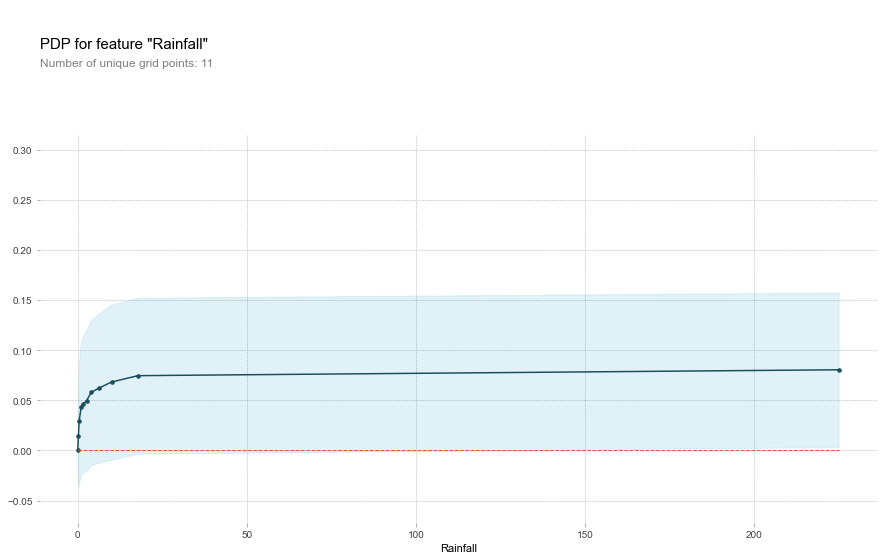

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

X_test_encoded = OrdinalEncoder(cols=['Date','Location']).fit_transform(X_test)

def pdpplot(feature):
    
    isolated = pdp_isolate(
        model=best_pipe, 
        dataset=X_test_encoded, 
        model_features=X_test_encoded.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=30 # default=10
    )
    pdp_plot(isolated, feature_name=feature)

pdpplot('Rainfall')

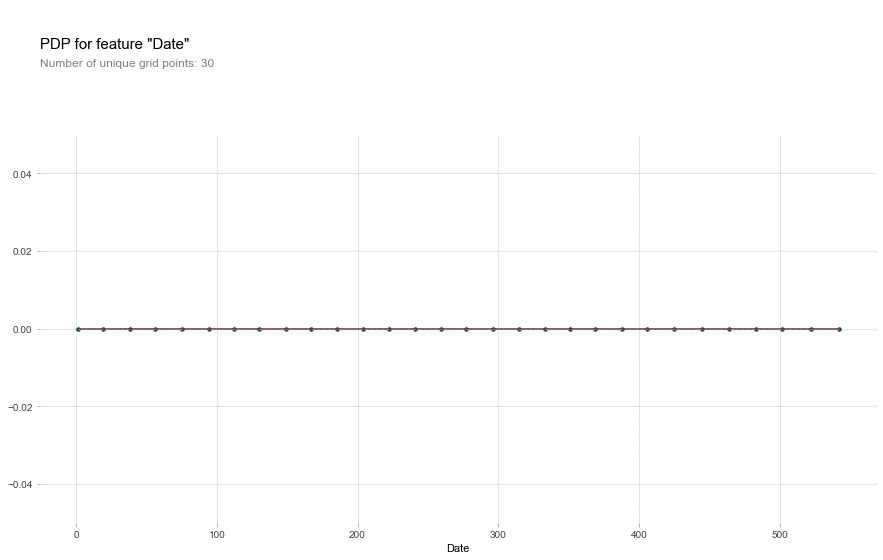

In [32]:
pdpplot('Date')

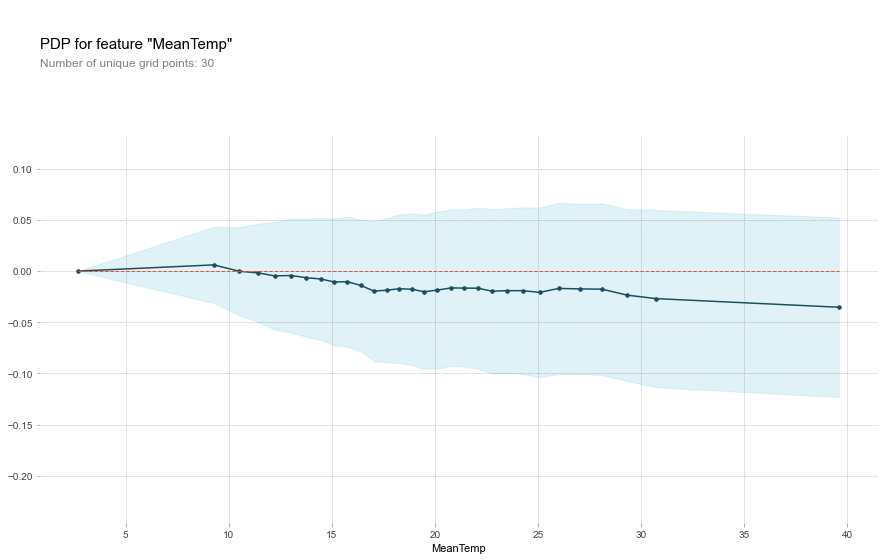

In [34]:
pdpplot('MeanTemp')

## Conclusion

- 호주 기상 데이터를 바탕으로 다음날 비가 내렸는지를 예측해 보았다.
- EDA 로 결측치 및 feature correlation 확인하였고, 특성공학을 수행하였다.
- Imbalanced 되어 있는 Target 에 대해 oversampling하여 훈련셋을 만들었다.
- LogisticRegression, DecisionTree, LightGBM, RandomForestClassifier 로 각각 CV를 적용한 모델 훈련 결과를 비교하였다.
- 가장 결과가 잘 나온 RandomForest 로 test 데이터에 적용해 보았고, baseline model 보다 상당한 성능 향상을 보였다.
- PDP Plot으로 몇 가지 feature들이 타겟 예측에 어떻게 기여했는지 살펴보았다.
- **모델이 어느 정도 날씨 예측 향상에 기여했다는 것을 확인했다.**

**아쉬운 점**
- feature importance를 살펴보지 못했다.
- 여전히 비가 오는 경우 예측의 recall 점수가 너무 낮았다.
- 좀더 다양한 모델과 hyperparameter 튜닝을 해보지 못해 아쉬웠다.